In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

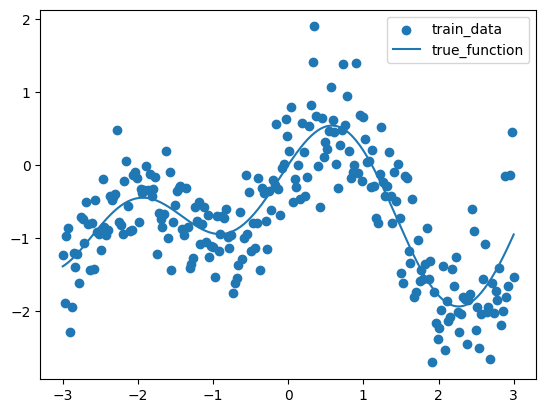

In [3]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [4]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [5]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [6]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

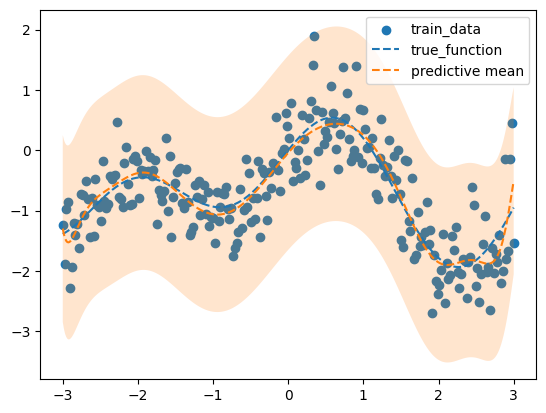

In [7]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [13]:
def log_evidence(lamb, X, y, alpha):
    N = X.shape[0]
    M = X.shape[1]

    A = lamb * np.eye(M) + alpha * (X.T @ X)

    sign_A, logdet_A = np.linalg.slogdet(A)
    if sign_A <= 0:
        return -np.inf

    r = X.T @ y
    z = np.linalg.solve(A, r)

    yTy = float(y.T @ y)
    quad = alpha * (yTy - alpha * float(r.T @ z))

    logdet_C = (N - M) * np.log(1.0 / alpha) + M * (-np.log(lamb)) + logdet_A

    log_ev = -0.5 * (N * np.log(2 * np.pi) + logdet_C + quad)
    return float(log_ev)

Лучшая lambda: 13.5542, log-evidence = -273.910


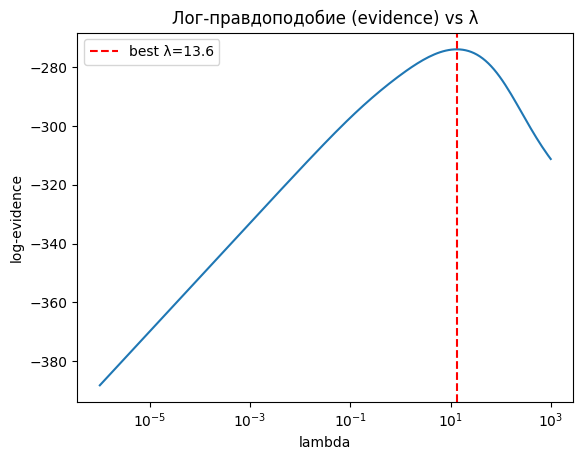

In [14]:
lambdas = np.logspace(-6, 3, 160)
log_evs = np.array([log_evidence(lmb, X, y, alpha) for lmb in lambdas])

best_idx = int(np.nanargmax(log_evs))
best_lamb = float(lambdas[best_idx])
best_logev = float(log_evs[best_idx])

print(f"Лучшая lambda: {best_lamb:.6g}, log-evidence = {best_logev:.3f}")

plt.figure()
plt.semilogx(lambdas, log_evs)
plt.axvline(best_lamb, color='r', linestyle='--', label=f'best λ={best_lamb:.3g}')
plt.xlabel('lambda')
plt.ylabel('log-evidence')
plt.title('Лог-правдоподобие (evidence) vs λ')
plt.legend()
plt.show()


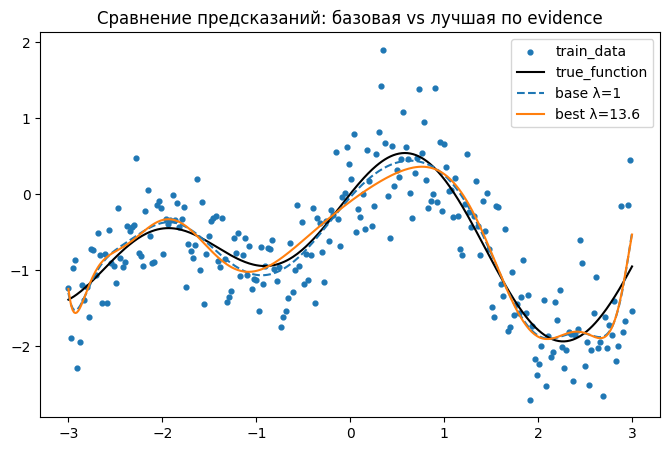

In [15]:
A_base = lamb * np.eye(X.shape[1]) + alpha * (X.T @ X)
mean_base = alpha * np.linalg.solve(A_base, X.T @ y)
mean_pred_base = X_new @ mean_base

A_best = best_lamb * np.eye(X.shape[1]) + alpha * (X.T @ X)
mean_best = alpha * np.linalg.solve(A_best, X.T @ y)
mean_pred_best = X_new @ mean_best

plt.figure(figsize=(8,5))
plt.scatter(x, y, s=12, label='train_data')
plt.plot(x_new, f_true(x_new), color='k', linewidth=1.5, label='true_function')
plt.plot(x_new, mean_pred_base, linestyle='--', label=f'base λ={lamb:.3g}')
plt.plot(x_new, mean_pred_best, linestyle='-', label=f'best λ={best_lamb:.3g}')
plt.legend()
plt.title('Сравнение предсказаний: базовая vs лучшая по evidence')
plt.show()
